# BabyGAN 教程

BabyGAN 是一个基于 StyleGAN 的儿童脸部预测器。<br>主要预测方法为：使用基于 GAN 架构的神经网络模型，从输入的父母图像中提取出潜伏表征，之后使用算法将它们按一定比例混合。<br>使用延迟方向（latency direction），你可以改变各种参数：年龄、脸部位置、情绪和性别。

**GitHub 仓库: [BabyGAN](https://github.com/tg-bomze/BabyGAN)**(*创建者: [Denis Malimonov](https://github.com/tg-bomze)*)  

**神经网络: [StyleGAN](https://github.com/NVlabs/stylegan)** (*创建者: [Tero Karras](https://research.nvidia.com/person/tero-karras), [Samuli Laine](https://research.nvidia.com/person/samuli-laine), [Timo Aila](https://research.nvidia.com/person/timo-aila)*)

**编码器: [stylegan-encoder](https://github.com/pbaylies/stylegan-encoder)** *(创建者: [Peter Baylies](https://github.com/pbaylies), [Dmitry Nikitko](https://github.com/Puzer))*

## 准备工作

In [2]:
# tensorflow 版本为 1.15
! pip install -U moviepy
! pip install https://github.com/podgorskiy/dnnlib/releases/download/0.0.1/dnnlib-0.0.1-py3-none-any.whl

import os
import cv2
import math
import pickle
import imageio
import warnings
import PIL.Image
import numpy as np
from PIL import Image
import tensorflow as tf
from random import randrange
import moviepy.editor as mpy
import matplotlib.pyplot as plt
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
warnings.filterwarnings("ignore")

def get_watermarked(pil_image: Image) -> Image:
  try:
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    (h, w) = image.shape[:2]
    image = np.dstack([image, np.ones((h, w), dtype="uint8") * 255])
    pct = 0.08
    full_watermark = cv2.imread('/openbayes/home/BabyGAN/media/logo.png', cv2.IMREAD_UNCHANGED)
    (fwH, fwW) = full_watermark.shape[:2]
    wH = int(pct * h*2)
    wW = int((wH * fwW) / fwH*0.1)
    watermark = cv2.resize(full_watermark, (wH, wW), interpolation=cv2.INTER_AREA)
    overlay = np.zeros((h, w, 4), dtype="uint8")
    (wH, wW) = watermark.shape[:2]
    overlay[h - wH - 10 : h - 10, 10 : 10 + wW] = watermark
    output = image.copy()
    cv2.addWeighted(overlay, 0.5, output, 1.0, 0, output)
    rgb_image = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb_image)
  except: return pil_image

def generate_final_images(latent_vector, direction, coeffs, i):
    new_latent_vector = latent_vector.copy()
    new_latent_vector[:8] = (latent_vector + coeffs*direction)[:8]
    new_latent_vector = new_latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(new_latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    if size[0] >= 512: img = get_watermarked(img)
    img_path = "/openbayes/home/BabyGAN/for_animation/" + str(i) + ".png"
    img.thumbnail(animation_size, PIL.Image.ANTIALIAS)
    img.save(img_path)
    face_img.append(imageio.imread(img_path))
    clear_output()
    return img

def generate_final_image(latent_vector, direction, coeffs):
    new_latent_vector = latent_vector.copy()
    new_latent_vector[:8] = (latent_vector + coeffs*direction)[:8]
    new_latent_vector = new_latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(new_latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    if size[0] >= 512: img = get_watermarked(img)
    img.thumbnail(size, PIL.Image.ANTIALIAS)
    img.save("face.png")
    return img

def plot_three_images(imgB, fs = 10):
  f, axarr = plt.subplots(1,3, figsize=(fs,fs))
  axarr[0].imshow(Image.open('/openbayes/home/BabyGAN/aligned_images/father_01.png'))
  axarr[0].title.set_text("Father's photo")
  axarr[1].imshow(imgB)
  axarr[1].title.set_text("Child's photo")
  axarr[2].imshow(Image.open('/openbayes/home/BabyGAN/aligned_images/mother_01.png'))
  axarr[2].title.set_text("Mother's photo")
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

clear_output()

In [3]:
# 下载模型及相关文件
!rm -rf sample_data
!git clone https://github.com/tg-bomze/BabyGAN.git
%cd /openbayes/home/BabyGAN
!mkdir aligned_images data father_image mother_image

fatal: destination path 'BabyGAN' already exists and is not an empty directory.
/output/BabyGAN
mkdir: cannot create directory ‘aligned_images’: File exists
mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘father_image’: File exists
mkdir: cannot create directory ‘mother_image’: File exists


In [4]:
import dnnlib
import dnnlib.tflib as tflib
from encoder.generator_model import Generator

age_direction = np.load('/openbayes/home/BabyGAN/ffhq_dataset/latent_directions/age.npy')
horizontal_direction = np.load('/openbayes/home/BabyGAN/ffhq_dataset/latent_directions/angle_horizontal.npy')
vertical_direction = np.load('/openbayes/home/BabyGAN/ffhq_dataset/latent_directions/angle_vertical.npy')
eyes_open_direction = np.load('/openbayes/home/BabyGAN/ffhq_dataset/latent_directions/eyes_open.npy')
gender_direction = np.load('/openbayes/home/BabyGAN/ffhq_dataset/latent_directions/gender.npy')
smile_direction = np.load('/openbayes/home/BabyGAN/ffhq_dataset/latent_directions/smile.npy')

clear_output()

In [5]:
# 保存预训练模型的权重，并装入Google Drive。
# 从https://drive.google.com/drive/folders/1xwqqG0HkLe2AiXxjC-XK8OfvMKT1jBlp下载文件，已下载完成

## 准备父母图片

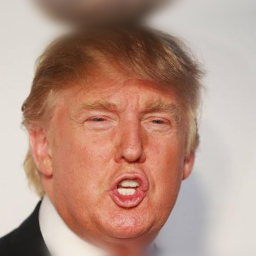

In [6]:
# 下载你喜欢的人像图片至 father_image 文件夹中，注意图片命名应为 father，后缀不限

!python align_images.py /openbayes/home/BabyGAN/father_image /openbayes/home/BabyGAN/aligned_images
clear_output()

if os.path.isfile('/openbayes/home/BabyGAN/aligned_images/father_01.png'):
  pil_father = Image.open('/openbayes/home/BabyGAN/aligned_images/father_01.png')
  (fat_width, fat_height) = pil_father.size
  resize_fat = max(fat_width, fat_height)/256
  display(pil_father.resize((int(fat_width/resize_fat), int(fat_height/resize_fat))))
else: raise ValueError('No face was found or there is more than one in the photo.')

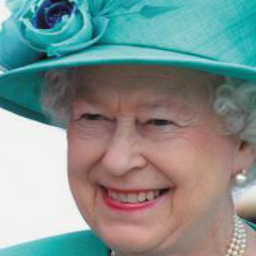

In [7]:
# 下载你喜欢的人像图片至 mother_image 文件夹中，注意图片命名应为 mother，后缀不限

!python align_images.py /openbayes/home/BabyGAN/mother_image /openbayes/home/BabyGAN/aligned_images
clear_output()

if os.path.isfile('/openbayes/home/BabyGAN/aligned_images/mother_01.png'):
  pil_mother = Image.open('/openbayes/home/BabyGAN/aligned_images/mother_01.png')
  (mot_width, mot_height) = pil_mother.size
  resize_mot = max(mot_width, mot_height)/256
  display(pil_mother.resize((int(mot_width/resize_mot), int(mot_height/resize_mot))))
else: raise ValueError('No face was found or there is more than one in the photo.')

In [8]:
# 获取潜伏表征，此过程可能花费数分钟

'''
#use_pretraineg_model = True #@param {type:"boolean"}
if use_pretraineg_model == False:
  !rm finetuned_resnet.h5
  !python train_resnet.py \
  --test_size 256 \
  --batch_size 1024 \
  --loop 1 \
  --max_patience 1'''

#!python encode_images.py --help
!python encode_images.py \
  --early_stopping False \
  --lr=0.25 \
  --batch_size=2 \
  --iterations=100 \
  --output_video=False \
  /openbayes/home/BabyGAN/aligned_images \
  /openbayes/home/BabyGAN/generated_images \
  /openbayes/home/BabyGAN/latent_representations

tflib.init_tf()
URL_FFHQ = "/openbayes/home/BabyGAN/karras2019stylegan-ffhq-1024x1024.pkl"
with dnnlib.util.open_url(URL_FFHQ, cache_dir='cache') as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)
generator = Generator(Gs_network, batch_size=1, randomize_noise=False)
model_scale = int(2*(math.log(1024,2)-1))

clear_output()
if len(os.listdir('/openbayes/home/BabyGAN/generated_images')) == 2:
  first_face = np.load('/openbayes/home/BabyGAN/latent_representations/father_01.npy')
  second_face = np.load('/openbayes/home/BabyGAN/latent_representations/mother_01.npy')
  print("潜伏表征的生成已经完成了！现在开始有趣的部分。")
else: raise ValueError('Something wrong. It may be impossible to read the face in the photos. Upload other photos and try again.')

潜伏表征的生成已经完成了！现在开始有趣的部分。


## 生成孩子图像

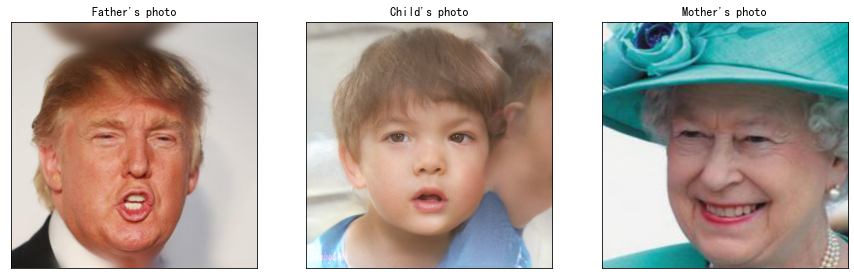

In [9]:
# 生成一个孩子的脸
# genes_influence: 哪个父母的基因会占优势，以及占多大的优势。
# 越接近0，父亲的影响越大；越接近1，母亲的影响越大。
genes_influence = 0.3 # 取值在 0.01 ~ 0.99，可以自行调整
# person_age: 孩子的大致年龄
person_age = 15 # 取值在 10 ~ 50，可以自行调整（仅整数）
# resolution: 下载图像的分辨率
resolution = "512" # 取值范围： [256, 512, 1024]
# style: 图片风格（不改变生成图片人物样貌，仅改变亮度、对比度等图片特征）
style = "Default" # 取值范围： ["Default", "Father's photo", "Mother's photo"]
if style == "Father's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**genes_influence).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (lr*first_face) + (rl*second_face)
elif style == "Mother's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**(1-genes_influence)).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (rl*first_face) + (lr*second_face)
else: hybrid_face = ((1-genes_influence)*first_face)+(genes_influence*second_face)
intensity = -((person_age/5)-6)

size = int(resolution), int(resolution)
face = generate_final_image(hybrid_face, age_direction, intensity)
plot_three_images(face, fs = 15)

In [10]:
# 生成孩子性别平稳变化的动画。
# person_age: 孩子的大致年龄
person_age = 40 # 取值在 10 ~ 50，可以自行调整（仅整数）
# animation_resolution: 生成动画的分辨率
animation_resolution = "512" # 取值范围： [256, 512, 1024]
# frames_number: 帧数
# 帧数越高，动画帧与帧之间的过渡越平滑。
frames_number = 50 # 取值在 10 ~ 50，可以自行调整（仅整数）

!rm -rf /openbayes/home/BabyGAN/for_animation
!mkdir /openbayes/home/BabyGAN/for_animation
face_img = []

intensity = -((person_age/5)-6)
animation_size = int(animation_resolution), int(animation_resolution)

for i in range(1, frames_number):
  gender_influence = i/frames_number
  hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
  face = generate_final_images(hybrid_face, age_direction, intensity, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(frames_number)))

for j in reversed(face_img):
  face_img.append(j)

animation_name = str(person_age) + "_years.mp4"

imageio.mimsave('/openbayes/home/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

display(mpy.ipython_display('/openbayes/home/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

In [11]:
# 生成孩子年龄平稳变化的动画。
# gender_influence: 哪个父母的基因会占优势，以及占多大的优势。
# 越接近0，父亲的影响越大；越接近1，母亲的影响越大。
gender_influence = 0.6 # 取值在 0.01 ~ 0.99，可以自行调整
# animation_resolution: 生成动画的分辨率
animation_resolution = "512" # 取值范围： [256, 512, 1024]
# frames_number: 帧数
# 帧数越高，动画帧与帧之间的过渡越平滑。
frames_number = 50 # 取值在 10 ~ 50，可以自行调整（仅整数）

!rm -rf /openbayes/home/BabyGAN/for_animation
!mkdir /openbayes/home/BabyGAN/for_animation
face_img = []

hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
animation_size = int(animation_resolution), int(animation_resolution)

for i in range(0, frames_number, 1):
  intensity = (8*(i/(frames_number-1)))-4
  generate_final_images(hybrid_face, age_direction, intensity, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(frames_number)))

for j in reversed(face_img):
  face_img.append(j)

if gender_influence <= 0.3:
  animation_name = "boy.mp4"
elif gender_influence >= 0.7:
  animation_name = "girl.mp4"
else:
  animation_name = "animation.mp4"

imageio.mimsave('/openbayes/home/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

display(mpy.ipython_display('/openbayes/home/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

## 生成特殊的孩子图像

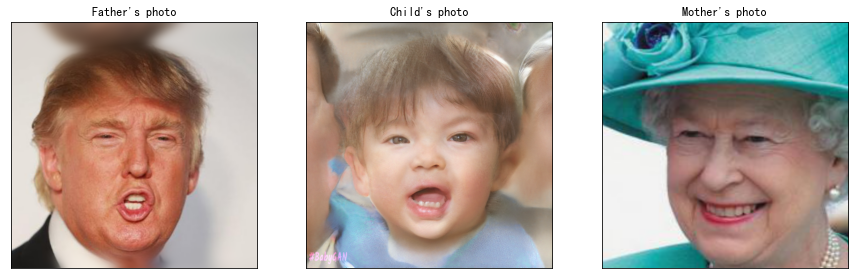

In [12]:
# 改变孩子脸部的参数
# genes_influence: 哪个父母的基因会占优势，以及占多大的优势。
# 越接近0，父亲的影响越大；越接近1，母亲的影响越大。
genes_influence = 0.3 # 取值在 0.01 ~ 0.99，可以自行调整
# style: 图片风格（不改变生成图片人物样貌，仅改变亮度、对比度等图片特征）
style = "Default" # 取值范围： ["Default", "Father's photo", "Mother's photo"]
# resolution: 下载图像的分辨率
resolution = "512" # 取值范围： [256, 512, 1024]
# 具体参数调整：（以下参数取值范围均为 -100 ~ 100， 整数）
horizontal = -50 # 横向
vertical = 0 # 纵向
eyes_open = 10 # 眼睛睁开程度
gender = 0 # 性别
smile = 100 # 笑容
age = -100 # 年龄

horizontal_intensity = horizontal/50
vertical_intensity = vertical/50
eyes_open_intensity = -(eyes_open/25)
gender_intensity = gender/100
smile_intensity = smile/100
age_intensity = -(age/25)

if style == "Father's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**genes_influence).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (lr*first_face) + (rl*second_face)
elif style == "Mother's photo": 
  lr = ((np.arange(1,model_scale+1)/model_scale)**(1-genes_influence)).reshape((model_scale,1))
  rl = 1-lr
  hybrid_face = (rl*first_face) + (lr*second_face)
else: hybrid_face = ((1-genes_influence)*first_face)+(genes_influence*second_face)

direction_intensity = (horizontal_direction*horizontal_intensity) + (vertical_direction*vertical_intensity) + (eyes_open_direction*eyes_open_intensity) + (gender_direction*gender_intensity) + (smile_direction*smile_intensity) + (age_direction*age_intensity)

size = int(resolution), int(resolution)

face = generate_final_image(hybrid_face, direction_intensity, 1)
plot_three_images(face, fs = 15)

In [13]:
# 生成一个某项参数变化的动画
# gender_influence: 哪个父母的基因会占优势，以及占多大的优势。
# 越接近0，父亲的影响越大；越接近1，母亲的影响越大。
gender_influence = 0.2 # 取值在 0.01 ~ 0.99，可以自行调整
# animation_resolution: 生成动画的分辨率
animation_resolution = "512" # 取值范围： [256, 512, 1024]
# frames_number: 帧数
# 帧数越高，动画帧与帧之间的过渡越平滑。
frames_number = 50 # 取值在 10 ~ 50，可以自行调整（仅整数）
# dir_str: 动画的参数选择
dir_str = "horizontal" # 取值范围： ["horizontal", "vertical", "eyes_open", "gender", "smile", "age"]

!rm -rf /openbayes/home/BabyGAN/for_animation
!mkdir /openbayes/home/BabyGAN/for_animation
face_img = []

hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
animation_size = int(animation_resolution), int(animation_resolution)

for i in range(0, frames_number, 1):
  intensity = (100*(i/(frames_number-1)))-50
  
  horizontal_intensity = intensity/25
  vertical_intensity = intensity/25
  eyes_open_intensity = -(intensity/12.5)
  gender_intensity = intensity/50
  smile_intensity = intensity/50
  age_intensity = -(intensity/12.5)

  horizontal = horizontal_direction * horizontal_intensity
  vertical = vertical_direction * vertical_intensity
  eyes_open = eyes_open_direction * eyes_open_intensity
  gender = gender_direction * gender_intensity
  smile = smile_direction * smile_intensity
  age = age_direction * age_intensity
    
  select_map = {
    "horizontal": horizontal,
    "vertical": vertical,
    "eyes_open": eyes_open,
    "gender": gender,
    "smile": smile,
    "age": age,
  }

  dir_int = select_map[dir_str]
    
  generate_final_images(hybrid_face, dir_int, 1, i)
  clear_output()
  print(str(i) + " of {} photo generated".format(str(frames_number)))

for j in reversed(face_img):
  face_img.append(j)

if gender_influence <= 0.3:
  animation_name = "boy.mp4"
elif gender_influence >= 0.7:
  animation_name = "girl.mp4"
else:
  animation_name = "animation.mp4"

imageio.mimsave('/openbayes/home/BabyGAN/for_animation/'+animation_name, face_img)
clear_output()

display(mpy.ipython_display('/openbayes/home/BabyGAN/for_animation/'+animation_name, height=400, autoplay=1, loop=1))

In [14]:
# 使用3个参数生成改变孩子脸部的动画
# gender_influence: 哪个父母的基因会占优势，以及占多大的优势。
# 越接近0，父亲的影响越大；越接近1，母亲的影响越大。
gender_influence = 0.5 # 取值在 0.01 ~ 0.99，可以自行调整
# animation_resolution: 生成动画的分辨率
animation_resolution = "512" # 取值范围： [256, 512, 1024]
# frames: 帧数
# 帧数越高，动画帧与帧之间的过渡越平滑。
frames = 50 # 取值在 10 ~ 100，可以自行调整（仅整数）
# 选择参数及其影响力
# 第一个参数
parameter1 = "angle_horizontal" # 取值范围：["age", "angle_horizontal", "angle_vertical", "eyes_open", "gender", "smile"]
intensity1 = 0.5 # 取值在 -5 ~ 5
# 第二个参数
parameter2 = "eyes_open" # 取值范围：["age", "angle_horizontal", "angle_vertical", "eyes_open", "gender", "smile"]
intensity2 = 5 # 取值在 -5 ~ 5
# 第三个参数
parameter3 = "gender" # 取值范围：["age", "angle_horizontal", "angle_vertical", "eyes_open", "gender", "smile"]
intensity3 = 0.2 # 取值在 -5 ~ 5

!rm -rf /openbayes/home/BabyGAN/for_animation
!mkdir /openbayes/home/BabyGAN/for_animation
face_img = []

hybrid_face = ((1-gender_influence)*first_face)+(gender_influence*second_face)
animation_size = int(animation_resolution), int(animation_resolution)
direction_file1 = np.load('/openbayes/home/BabyGAN/ffhq_dataset/latent_directions/' + parameter1 + '.npy')

if intensity1 == 0: intensity1 += 0.001
coeffs1 = []
for i in range(0, frames):
  coeffs1.append(round((i*intensity1)/frames,3))

direction_file2 = np.load('/openbayes/home/BabyGAN/ffhq_dataset/latent_directions/' + parameter2 + '.npy')
if intensity2 == 0: intensity2 += 0.001
coeffs2 = []
for i in range(0, frames):
  coeffs2.append(round((i*intensity2)/frames,3))

direction_file3 = np.load('/openbayes/home/BabyGAN/ffhq_dataset/latent_directions/' + parameter3 + '.npy')
if intensity3 == 0: intensity3 += 0.001
coeffs3 = []
for i in range(0, frames):
  coeffs3.append(round((i*intensity3)/frames,3))

for i in range(frames):
  direction_intensity1 = direction_file1 * coeffs1[i]
  direction_intensity2 = direction_file2 * coeffs2[i]
  direction_intensity3 = direction_file3 * coeffs3[i]
  direction_intensity = direction_intensity1 + direction_intensity2 + direction_intensity3
  generate_final_images(hybrid_face, direction_intensity, 1, i)
  clear_output()
  print('Generated ' + str(i) + ' photos of ' + str(frames))

add_invert = True
img = os.listdir("for_animation")
img.sort()
clear_output()
print('The animation is being generated. Please wait.')

for j in reversed(face_img):
  face_img.append(j)
face_img = np.array(face_img)
imageio.mimsave("/openbayes/home/BabyGAN/for_animation/3param.mp4", face_img)
clear_output()

display(mpy.ipython_display("/openbayes/home/BabyGAN/for_animation/3param.mp4", height=400, autoplay=1, loop=1))